In [14]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytest
from matplotlib.gridspec import GridSpec
from scipy.stats import randint, uniform
from sklearn.model_selection import ShuffleSplit
from kerastuner import HyperParameters as hp

import pyMAISE as mai

settings = {
    "verbosity": 1,
    "random_state": 42,
    "test_size": 0.3,
    "num_configs_saved": 5,
    "regression": True,
}


global_settings = mai.settings.init(settings_changes=settings)

preprocessor = mai.load_MITR()

data = preprocessor.min_max_scale()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Reading data from ['/home/myerspat/dev/pyMAISE/pyMAISE/data/crx.csv', '/home/myerspat/dev/pyMAISE/pyMAISE/data/powery.csv']
MinMax scaling data


2023-09-25 22:49:18.480195: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-25 22:49:18.480244: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## pyMAISE Initialization

First we initialize pyMAISE with the following 4 parameters:

- `verbosity`: 0 $\rightarrow$ pyMAISE prints no outputs,
- `random_state`: None $\rightarrow$ No random seed is set,
- `test_size`: 0.3 $\rightarrow$ 30% of the data is used for testing,
- `num_configs_saved`: 5 $\rightarrow$ The top 5 hyper-parameter configurations are saved for each model.

With pyMAISE initialized we can load the preprocessor for this data set using `load_fp()`.

In [70]:
structural_hyperparameters = {
    "dense_input": {
        "units": mai.Int(min_value=25, max_value=300, step=10),
        "input_dim": preprocessor.inputs.shape[1],
        "activation": "relu",
        "kernel_initializer": "normal",
    },
    "dense_hidden": {
        "units": mai.Int(min_value=25, max_value=300, step=10),
        "activation": "relu",
        "kernel_initializer": "normal",
        "num_layers": mai.Int(min_value=1, max_value=3),
    },
    "dense_output": {
        "units": 22,
        "input_dim": None,
        "activation": "linear",
        "kernel_initializer": "normal",
    },
}

adam = {
    "learning_rate": 1e-3,
}


model_settings = {
    "models": ["linear", "fnn"],
    "fnn": {
        "structural_params": structural_hyperparameters,
        "optimizer": "adam",
        "adam": adam,
        "compile_params": {
            "loss": "mean_absolute_error",
            "metrics": ["mean_absolute_error"],
        },
        "fitting_params": {
            "batch_size": 8,
            "epochs": 50,
            "validation_split": 0.15,
        },
    },
}

tuning = mai.Tuning(data=data, model_settings=model_settings)
bayesian_search = tuning.nn_bayesian_search(
    models = ["fnn"],
    objective = 'mean_absolute_error',
    max_trials = 10,
)

Trial 10 Complete [00h 00m 05s]
mean_absolute_error: 0.009911217726767063

Best mean_absolute_error So Far: 0.007831980474293232
Total elapsed time: 00h 00m 52s
-- fnn
Search space summary
Default search space size: 5
dense_input0_units (Int)
{'default': None, 'conditions': [], 'min_value': 25, 'max_value': 300, 'step': 10, 'sampling': 'linear'}
dense_hidden_num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
dense_hidden0_units (Int)
{'default': None, 'conditions': [], 'min_value': 25, 'max_value': 300, 'step': 10, 'sampling': 'linear'}
dense_hidden1_units (Int)
{'default': None, 'conditions': [], 'min_value': 25, 'max_value': 300, 'step': 10, 'sampling': 'linear'}
dense_hidden2_units (Int)
{'default': None, 'conditions': [], 'min_value': 25, 'max_value': 300, 'step': 10, 'sampling': 'linear'}
None
Results summary
Results in ./best_hp
Showing 10 best trials
Objective(name="mean_absolute_error", direction="min")

Trial 0

In [43]:
new_model_settings = {
    "fnn": {
        "fitting_params":{
            "epochs": 200,
        }
    }
}
postprocessor = mai.PostProcessor(
    data=data,
    models_list=[bayesian_search],
    new_model_settings=new_model_settings,
)

Epoch 1/200
75/75 [==============================] - 0s 2ms/step - loss: 0.2396 - mean_absolute_error: 0.2396 - val_loss: 0.1692 - val_mean_absolute_error: 0.1692
Epoch 2/200
75/75 [==============================] - 0s 1ms/step - loss: 0.1395 - mean_absolute_error: 0.1395 - val_loss: 0.0914 - val_mean_absolute_error: 0.0914
Epoch 3/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0657 - mean_absolute_error: 0.0657 - val_loss: 0.0434 - val_mean_absolute_error: 0.0434
Epoch 4/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0364 - mean_absolute_error: 0.0364 - val_loss: 0.0229 - val_mean_absolute_error: 0.0229
Epoch 5/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0163 - mean_absolute_error: 0.0163 - val_loss: 0.0145 - val_mean_absolute_error: 0.0145
Epoch 6/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0132 - mean_absolute_error: 0.0132 - val_loss: 0.0163 - val_mean_absolute_error: 0.0163
Epoch 7/200
75/75 [===

75/75 [==============================] - 0s 1ms/step - loss: 0.0083 - mean_absolute_error: 0.0083 - val_loss: 0.0105 - val_mean_absolute_error: 0.0105
Epoch 51/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0078 - mean_absolute_error: 0.0078 - val_loss: 0.0099 - val_mean_absolute_error: 0.0099
Epoch 52/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0083 - mean_absolute_error: 0.0083 - val_loss: 0.0100 - val_mean_absolute_error: 0.0100
Epoch 53/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0081 - mean_absolute_error: 0.0081 - val_loss: 0.0074 - val_mean_absolute_error: 0.0074
Epoch 54/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0081 - mean_absolute_error: 0.0081 - val_loss: 0.0089 - val_mean_absolute_error: 0.0089
Epoch 55/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0087 - mean_absolute_error: 0.0087 - val_loss: 0.0113 - val_mean_absolute_error: 0.0113
Epoch 56/200
75/75 [=========

Epoch 100/200
75/75 [==============================] - 0s 992us/step - loss: 0.0072 - mean_absolute_error: 0.0072 - val_loss: 0.0101 - val_mean_absolute_error: 0.0101
Epoch 101/200
75/75 [==============================] - 0s 984us/step - loss: 0.0070 - mean_absolute_error: 0.0070 - val_loss: 0.0080 - val_mean_absolute_error: 0.0080
Epoch 102/200
75/75 [==============================] - 0s 949us/step - loss: 0.0071 - mean_absolute_error: 0.0071 - val_loss: 0.0068 - val_mean_absolute_error: 0.0068
Epoch 103/200
75/75 [==============================] - 0s 991us/step - loss: 0.0069 - mean_absolute_error: 0.0069 - val_loss: 0.0094 - val_mean_absolute_error: 0.0094
Epoch 104/200
75/75 [==============================] - 0s 996us/step - loss: 0.0076 - mean_absolute_error: 0.0076 - val_loss: 0.0093 - val_mean_absolute_error: 0.0093
Epoch 105/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0075 - mean_absolute_error: 0.0075 - val_loss: 0.0084 - val_mean_absolute_error: 0.0084


75/75 [==============================] - 0s 1ms/step - loss: 0.0065 - mean_absolute_error: 0.0065 - val_loss: 0.0070 - val_mean_absolute_error: 0.0070
Epoch 150/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0064 - mean_absolute_error: 0.0064 - val_loss: 0.0078 - val_mean_absolute_error: 0.0078
Epoch 151/200
75/75 [==============================] - 0s 972us/step - loss: 0.0066 - mean_absolute_error: 0.0066 - val_loss: 0.0075 - val_mean_absolute_error: 0.0075
Epoch 152/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0068 - mean_absolute_error: 0.0068 - val_loss: 0.0079 - val_mean_absolute_error: 0.0079
Epoch 153/200
75/75 [==============================] - 0s 988us/step - loss: 0.0071 - mean_absolute_error: 0.0071 - val_loss: 0.0073 - val_mean_absolute_error: 0.0073
Epoch 154/200
75/75 [==============================] - 0s 982us/step - loss: 0.0067 - mean_absolute_error: 0.0067 - val_loss: 0.0069 - val_mean_absolute_error: 0.0069
Epoch 155/200
75/7

75/75 [==============================] - 0s 953us/step - loss: 0.0062 - mean_absolute_error: 0.0062 - val_loss: 0.0069 - val_mean_absolute_error: 0.0069
Epoch 199/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0065 - mean_absolute_error: 0.0065 - val_loss: 0.0074 - val_mean_absolute_error: 0.0074
Epoch 200/200
10/10 [==============================] - 0s 759us/step
Epoch 1/200
75/75 [==============================] - 0s 2ms/step - loss: 0.2504 - mean_absolute_error: 0.2504 - val_loss: 0.1689 - val_mean_absolute_error: 0.1689
Epoch 2/200
75/75 [==============================] - 0s 1ms/step - loss: 0.1416 - mean_absolute_error: 0.1416 - val_loss: 0.0951 - val_mean_absolute_error: 0.0951
Epoch 3/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0724 - mean_absolute_error: 0.0724 - val_loss: 0.0456 - val_mean_absolute_error: 0.0456
Epoch 4/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0424 - mean_absolute_error: 0.0424 - val_loss: 0.

75/75 [==============================] - 0s 1ms/step - loss: 0.0090 - mean_absolute_error: 0.0090 - val_loss: 0.0089 - val_mean_absolute_error: 0.0089
Epoch 48/200
75/75 [==============================] - 0s 997us/step - loss: 0.0084 - mean_absolute_error: 0.0084 - val_loss: 0.0097 - val_mean_absolute_error: 0.0097
Epoch 49/200
75/75 [==============================] - 0s 997us/step - loss: 0.0082 - mean_absolute_error: 0.0082 - val_loss: 0.0087 - val_mean_absolute_error: 0.0087
Epoch 50/200
75/75 [==============================] - 0s 987us/step - loss: 0.0085 - mean_absolute_error: 0.0085 - val_loss: 0.0087 - val_mean_absolute_error: 0.0087
Epoch 51/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0083 - mean_absolute_error: 0.0083 - val_loss: 0.0082 - val_mean_absolute_error: 0.0082
Epoch 52/200
75/75 [==============================] - 0s 984us/step - loss: 0.0078 - mean_absolute_error: 0.0078 - val_loss: 0.0079 - val_mean_absolute_error: 0.0079
Epoch 53/200
75/75 [=

Epoch 97/200
75/75 [==============================] - 0s 986us/step - loss: 0.0071 - mean_absolute_error: 0.0071 - val_loss: 0.0091 - val_mean_absolute_error: 0.0091
Epoch 98/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0083 - mean_absolute_error: 0.0083 - val_loss: 0.0098 - val_mean_absolute_error: 0.0098
Epoch 99/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0079 - mean_absolute_error: 0.0079 - val_loss: 0.0089 - val_mean_absolute_error: 0.0089
Epoch 100/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0072 - mean_absolute_error: 0.0072 - val_loss: 0.0096 - val_mean_absolute_error: 0.0096
Epoch 101/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0068 - mean_absolute_error: 0.0068 - val_loss: 0.0082 - val_mean_absolute_error: 0.0082
Epoch 102/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0074 - mean_absolute_error: 0.0074 - val_loss: 0.0085 - val_mean_absolute_error: 0.0085
Epoch 103/2

75/75 [==============================] - 0s 1ms/step - loss: 0.0073 - mean_absolute_error: 0.0073 - val_loss: 0.0093 - val_mean_absolute_error: 0.0093
Epoch 147/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0066 - mean_absolute_error: 0.0066 - val_loss: 0.0074 - val_mean_absolute_error: 0.0074
Epoch 148/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0065 - mean_absolute_error: 0.0065 - val_loss: 0.0091 - val_mean_absolute_error: 0.0091
Epoch 149/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0065 - mean_absolute_error: 0.0065 - val_loss: 0.0063 - val_mean_absolute_error: 0.0063
Epoch 150/200
75/75 [==============================] - 0s 983us/step - loss: 0.0060 - mean_absolute_error: 0.0060 - val_loss: 0.0073 - val_mean_absolute_error: 0.0073
Epoch 151/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0064 - mean_absolute_error: 0.0064 - val_loss: 0.0070 - val_mean_absolute_error: 0.0070
Epoch 152/200
75/75 [=

Epoch 196/200
75/75 [==============================] - 0s 990us/step - loss: 0.0063 - mean_absolute_error: 0.0063 - val_loss: 0.0071 - val_mean_absolute_error: 0.0071
Epoch 197/200
75/75 [==============================] - 0s 998us/step - loss: 0.0062 - mean_absolute_error: 0.0062 - val_loss: 0.0069 - val_mean_absolute_error: 0.0069
Epoch 198/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0059 - mean_absolute_error: 0.0059 - val_loss: 0.0080 - val_mean_absolute_error: 0.0080
Epoch 199/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0061 - mean_absolute_error: 0.0061 - val_loss: 0.0082 - val_mean_absolute_error: 0.0082
Epoch 200/200
10/10 [==============================] - 0s 706us/step
Epoch 1/200
75/75 [==============================] - 0s 2ms/step - loss: 0.2418 - mean_absolute_error: 0.2418 - val_loss: 0.1672 - val_mean_absolute_error: 0.1672
Epoch 2/200
75/75 [==============================] - 0s 1ms/step - loss: 0.1366 - mean_absolute_error: 0

75/75 [==============================] - 0s 946us/step - loss: 0.0085 - mean_absolute_error: 0.0085 - val_loss: 0.0099 - val_mean_absolute_error: 0.0099
Epoch 46/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0084 - mean_absolute_error: 0.0084 - val_loss: 0.0116 - val_mean_absolute_error: 0.0116
Epoch 47/200
75/75 [==============================] - 0s 983us/step - loss: 0.0082 - mean_absolute_error: 0.0082 - val_loss: 0.0091 - val_mean_absolute_error: 0.0091
Epoch 48/200
75/75 [==============================] - 0s 938us/step - loss: 0.0079 - mean_absolute_error: 0.0079 - val_loss: 0.0092 - val_mean_absolute_error: 0.0092
Epoch 49/200
75/75 [==============================] - 0s 982us/step - loss: 0.0080 - mean_absolute_error: 0.0080 - val_loss: 0.0080 - val_mean_absolute_error: 0.0080
Epoch 50/200
75/75 [==============================] - 0s 947us/step - loss: 0.0089 - mean_absolute_error: 0.0089 - val_loss: 0.0086 - val_mean_absolute_error: 0.0086
Epoch 51/200
75/75 

Epoch 95/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0070 - mean_absolute_error: 0.0070 - val_loss: 0.0075 - val_mean_absolute_error: 0.0075
Epoch 96/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0078 - mean_absolute_error: 0.0078 - val_loss: 0.0078 - val_mean_absolute_error: 0.0078
Epoch 97/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0073 - mean_absolute_error: 0.0073 - val_loss: 0.0080 - val_mean_absolute_error: 0.0080
Epoch 98/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0075 - mean_absolute_error: 0.0075 - val_loss: 0.0095 - val_mean_absolute_error: 0.0095
Epoch 99/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0077 - mean_absolute_error: 0.0077 - val_loss: 0.0084 - val_mean_absolute_error: 0.0084
Epoch 100/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0071 - mean_absolute_error: 0.0071 - val_loss: 0.0094 - val_mean_absolute_error: 0.0094
Epoch 101/200
7

75/75 [==============================] - 0s 1ms/step - loss: 0.0066 - mean_absolute_error: 0.0066 - val_loss: 0.0085 - val_mean_absolute_error: 0.0085
Epoch 145/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0064 - mean_absolute_error: 0.0064 - val_loss: 0.0101 - val_mean_absolute_error: 0.0101
Epoch 146/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0074 - mean_absolute_error: 0.0074 - val_loss: 0.0081 - val_mean_absolute_error: 0.0081
Epoch 147/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0065 - mean_absolute_error: 0.0065 - val_loss: 0.0067 - val_mean_absolute_error: 0.0067
Epoch 148/200
75/75 [==============================] - 0s 998us/step - loss: 0.0062 - mean_absolute_error: 0.0062 - val_loss: 0.0089 - val_mean_absolute_error: 0.0089
Epoch 149/200
75/75 [==============================] - 0s 962us/step - loss: 0.0067 - mean_absolute_error: 0.0067 - val_loss: 0.0076 - val_mean_absolute_error: 0.0076
Epoch 150/200
75/75 

75/75 [==============================] - 0s 990us/step - loss: 0.0061 - mean_absolute_error: 0.0061 - val_loss: 0.0079 - val_mean_absolute_error: 0.0079
Epoch 194/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0061 - mean_absolute_error: 0.0061 - val_loss: 0.0067 - val_mean_absolute_error: 0.0067
Epoch 195/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0060 - mean_absolute_error: 0.0060 - val_loss: 0.0076 - val_mean_absolute_error: 0.0076
Epoch 196/200
75/75 [==============================] - 0s 984us/step - loss: 0.0064 - mean_absolute_error: 0.0064 - val_loss: 0.0087 - val_mean_absolute_error: 0.0087
Epoch 197/200
75/75 [==============================] - 0s 997us/step - loss: 0.0059 - mean_absolute_error: 0.0059 - val_loss: 0.0069 - val_mean_absolute_error: 0.0069
Epoch 198/200
75/75 [==============================] - 0s 988us/step - loss: 0.0056 - mean_absolute_error: 0.0056 - val_loss: 0.0066 - val_mean_absolute_error: 0.0066
Epoch 199/200
75

75/75 [==============================] - 0s 977us/step - loss: 0.0081 - mean_absolute_error: 0.0081 - val_loss: 0.0103 - val_mean_absolute_error: 0.0103
Epoch 43/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0078 - mean_absolute_error: 0.0078 - val_loss: 0.0081 - val_mean_absolute_error: 0.0081
Epoch 44/200
75/75 [==============================] - 0s 980us/step - loss: 0.0079 - mean_absolute_error: 0.0079 - val_loss: 0.0097 - val_mean_absolute_error: 0.0097
Epoch 45/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0086 - mean_absolute_error: 0.0086 - val_loss: 0.0083 - val_mean_absolute_error: 0.0083
Epoch 46/200
75/75 [==============================] - 0s 993us/step - loss: 0.0084 - mean_absolute_error: 0.0084 - val_loss: 0.0106 - val_mean_absolute_error: 0.0106
Epoch 47/200
75/75 [==============================] - 0s 993us/step - loss: 0.0085 - mean_absolute_error: 0.0085 - val_loss: 0.0090 - val_mean_absolute_error: 0.0090
Epoch 48/200
75/75 [=

75/75 [==============================] - 0s 1ms/step - loss: 0.0067 - mean_absolute_error: 0.0067 - val_loss: 0.0077 - val_mean_absolute_error: 0.0077
Epoch 92/200
75/75 [==============================] - 0s 995us/step - loss: 0.0074 - mean_absolute_error: 0.0074 - val_loss: 0.0077 - val_mean_absolute_error: 0.0077
Epoch 93/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0074 - mean_absolute_error: 0.0074 - val_loss: 0.0079 - val_mean_absolute_error: 0.0079
Epoch 94/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0072 - mean_absolute_error: 0.0072 - val_loss: 0.0068 - val_mean_absolute_error: 0.0068
Epoch 95/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0067 - mean_absolute_error: 0.0067 - val_loss: 0.0082 - val_mean_absolute_error: 0.0082
Epoch 96/200
75/75 [==============================] - 0s 977us/step - loss: 0.0071 - mean_absolute_error: 0.0071 - val_loss: 0.0085 - val_mean_absolute_error: 0.0085
Epoch 97/200
75/75 [=====

75/75 [==============================] - 0s 1ms/step - loss: 0.0065 - mean_absolute_error: 0.0065 - val_loss: 0.0069 - val_mean_absolute_error: 0.0069
Epoch 141/200
75/75 [==============================] - 0s 985us/step - loss: 0.0063 - mean_absolute_error: 0.0063 - val_loss: 0.0069 - val_mean_absolute_error: 0.0069
Epoch 142/200
75/75 [==============================] - 0s 978us/step - loss: 0.0062 - mean_absolute_error: 0.0062 - val_loss: 0.0075 - val_mean_absolute_error: 0.0075
Epoch 143/200
75/75 [==============================] - 0s 980us/step - loss: 0.0063 - mean_absolute_error: 0.0063 - val_loss: 0.0083 - val_mean_absolute_error: 0.0083
Epoch 144/200
75/75 [==============================] - 0s 977us/step - loss: 0.0067 - mean_absolute_error: 0.0067 - val_loss: 0.0086 - val_mean_absolute_error: 0.0086
Epoch 145/200
75/75 [==============================] - 0s 975us/step - loss: 0.0065 - mean_absolute_error: 0.0065 - val_loss: 0.0071 - val_mean_absolute_error: 0.0071
Epoch 146/200


75/75 [==============================] - 0s 983us/step - loss: 0.0059 - mean_absolute_error: 0.0059 - val_loss: 0.0063 - val_mean_absolute_error: 0.0063
Epoch 190/200
75/75 [==============================] - 0s 987us/step - loss: 0.0065 - mean_absolute_error: 0.0065 - val_loss: 0.0073 - val_mean_absolute_error: 0.0073
Epoch 191/200
75/75 [==============================] - 0s 985us/step - loss: 0.0060 - mean_absolute_error: 0.0060 - val_loss: 0.0066 - val_mean_absolute_error: 0.0066
Epoch 192/200
75/75 [==============================] - 0s 992us/step - loss: 0.0060 - mean_absolute_error: 0.0060 - val_loss: 0.0088 - val_mean_absolute_error: 0.0088
Epoch 193/200
75/75 [==============================] - 0s 996us/step - loss: 0.0067 - mean_absolute_error: 0.0067 - val_loss: 0.0076 - val_mean_absolute_error: 0.0076
Epoch 194/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0063 - mean_absolute_error: 0.0063 - val_loss: 0.0072 - val_mean_absolute_error: 0.0072
Epoch 195/200


75/75 [==============================] - 0s 1ms/step - loss: 0.0089 - mean_absolute_error: 0.0089 - val_loss: 0.0088 - val_mean_absolute_error: 0.0088
Epoch 39/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0096 - mean_absolute_error: 0.0096 - val_loss: 0.0129 - val_mean_absolute_error: 0.0129
Epoch 40/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0099 - mean_absolute_error: 0.0099 - val_loss: 0.0093 - val_mean_absolute_error: 0.0093
Epoch 41/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0092 - val_loss: 0.0092 - val_mean_absolute_error: 0.0092
Epoch 42/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0089 - mean_absolute_error: 0.0089 - val_loss: 0.0088 - val_mean_absolute_error: 0.0088
Epoch 43/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0090 - mean_absolute_error: 0.0090 - val_loss: 0.0089 - val_mean_absolute_error: 0.0089
Epoch 44/200
75/75 [=========

75/75 [==============================] - 0s 1ms/step - loss: 0.0083 - mean_absolute_error: 0.0083 - val_loss: 0.0090 - val_mean_absolute_error: 0.0090
Epoch 89/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0083 - mean_absolute_error: 0.0083 - val_loss: 0.0082 - val_mean_absolute_error: 0.0082
Epoch 90/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0086 - mean_absolute_error: 0.0086 - val_loss: 0.0092 - val_mean_absolute_error: 0.0092
Epoch 91/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0078 - mean_absolute_error: 0.0078 - val_loss: 0.0090 - val_mean_absolute_error: 0.0090
Epoch 92/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0090 - mean_absolute_error: 0.0090 - val_loss: 0.0109 - val_mean_absolute_error: 0.0109
Epoch 93/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0080 - mean_absolute_error: 0.0080 - val_loss: 0.0089 - val_mean_absolute_error: 0.0089
Epoch 94/200
75/75 [=========

Epoch 138/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0076 - mean_absolute_error: 0.0076 - val_loss: 0.0080 - val_mean_absolute_error: 0.0080
Epoch 139/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0071 - mean_absolute_error: 0.0071 - val_loss: 0.0075 - val_mean_absolute_error: 0.0075
Epoch 140/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0077 - mean_absolute_error: 0.0077 - val_loss: 0.0080 - val_mean_absolute_error: 0.0080
Epoch 141/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0075 - mean_absolute_error: 0.0075 - val_loss: 0.0095 - val_mean_absolute_error: 0.0095
Epoch 142/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0082 - mean_absolute_error: 0.0082 - val_loss: 0.0080 - val_mean_absolute_error: 0.0080
Epoch 143/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0074 - mean_absolute_error: 0.0074 - val_loss: 0.0070 - val_mean_absolute_error: 0.0070
Epoch 144/

Epoch 188/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0068 - mean_absolute_error: 0.0068 - val_loss: 0.0080 - val_mean_absolute_error: 0.0080
Epoch 189/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0067 - mean_absolute_error: 0.0067 - val_loss: 0.0070 - val_mean_absolute_error: 0.0070
Epoch 190/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0074 - mean_absolute_error: 0.0074 - val_loss: 0.0099 - val_mean_absolute_error: 0.0099
Epoch 191/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0070 - mean_absolute_error: 0.0070 - val_loss: 0.0078 - val_mean_absolute_error: 0.0078
Epoch 192/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0069 - mean_absolute_error: 0.0069 - val_loss: 0.0090 - val_mean_absolute_error: 0.0090
Epoch 193/200
75/75 [==============================] - 0s 1ms/step - loss: 0.0070 - mean_absolute_error: 0.0070 - val_loss: 0.0065 - val_mean_absolute_error: 0.0065
Epoch 194/

In [69]:
postprocessor.metrics()

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
2,fnn,<keras_tuner.src.engine.hyperparameters.hyperp...,0.998835,0.005255,0.000047,0.006866,0.998835,0.005255,0.000047,0.007435
0,fnn,<keras_tuner.src.engine.hyperparameters.hyperp...,0.998407,0.006334,0.000064,0.007988,0.998407,0.006334,0.000064,0.008948
4,fnn,<keras_tuner.src.engine.hyperparameters.hyperp...,0.997987,0.007150,0.000079,0.008912,0.997987,0.007150,0.000079,0.009576
3,fnn,<keras_tuner.src.engine.hyperparameters.hyperp...,0.997983,0.007318,0.000082,0.009032,0.997983,0.007318,0.000082,0.009747
1,fnn,<keras_tuner.src.engine.hyperparameters.hyperp...,0.997753,0.007848,0.000094,0.009688,0.997753,0.007848,0.000094,0.010307


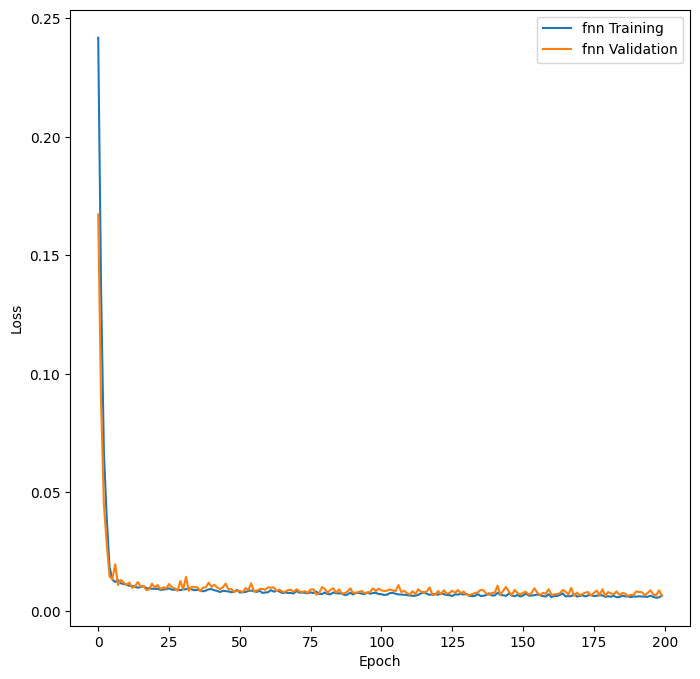

In [65]:
fig, ax = plt.subplots(figsize=(8,8))
ax = postprocessor.nn_learning_plot()